In [1]:
# common imports
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import joblib, glob
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning imports
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# display setup
pd.set_option("display.max_columns", None)  # the None parameter displays unlimited columns
plt.style.use('seaborn')  # for plots

# 1. Getting the Data

> Each participant has 3 csv files, one for each alignment state.

> Taking a look at a file should help gain insight to which DataFrame manipulations need to be implemented
> in the functions that will load the whole dataset.
>
> The 'HandRight' file contains right-hand movements which needs to be merged with the 'Alone' state files.
> Preparing it beforehand is more efficient since it will be used multiple times when loading the data.

In [2]:
# read right hand file
handright = pd.read_csv(r"extraFiles/HandRight.csv")

In [3]:
# display first 5 rows for a quick look
handright.head()

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,Pitch,Roll,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,128.2883,15478,right,1,15.67167,226.2064,20.26470,34.26665,-195.214700,-35.043020,0.270987,-0.017635,-0.277800,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
1,128.3048,15480,right,1,16.24119,222.9389,20.11781,36.16443,-180.093900,-4.052799,0.245085,-0.014770,-0.277763,47.54861,205.6568,86.42250,203.9553,47.88272,238.4482,0.0,0.243050,0.0
2,128.3218,15482,right,1,16.72461,220.9709,19.94972,26.35298,-95.088190,-11.157620,0.230796,-0.008779,-0.278792,48.15030,204.5182,86.35149,204.6231,45.35921,236.8544,0.0,0.281134,0.0
3,128.3384,15484,right,1,17.09016,219.7124,19.67679,19.46804,-61.755180,-21.303780,0.217681,-0.010759,-0.279768,48.64175,203.9989,86.16056,204.9939,44.18692,236.0927,0.0,0.277691,0.0
4,128.3551,15486,right,1,17.46017,219.3652,19.13128,21.94964,-8.355943,-35.081790,0.220696,-0.017380,-0.278629,48.93135,203.3777,85.59017,204.5952,42.68003,235.2896,0.0,0.283008,0.0


In [4]:
# DataFrame shape (rows, columns)
handright.shape

(4812, 22)

In [5]:
# description of data
handright.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4812 entries, 0 to 4811
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Time             4812 non-null   float64
 1    Frame ID        4812 non-null   int64  
 2    Hand Type       4812 non-null   object 
 3    # hands         4812 non-null   int64  
 4    Position X      4812 non-null   float64
 5    Position Y      4812 non-null   float64
 6    Position Z      4812 non-null   float64
 7    Velocity X      4812 non-null   float64
 8    Velocity Y      4812 non-null   float64
 9    Velocity Z      4812 non-null   float64
 10   Pitch           4812 non-null   float64
 11   Roll            4812 non-null   float64
 12   Yaw             4812 non-null   float64
 13   Wrist Pos X     4428 non-null   float64
 14   Wrist Pos Y     4428 non-null   float64
 15   Wrist Pos Z     4428 non-null   float64
 16   Elbow pos X     4428 non-null   float64
 17   Elbow Pos Y  

In [6]:
# show null values
handright.isna().sum()

Time                 0
 Frame ID            0
 Hand Type           0
 # hands             0
 Position X          0
 Position Y          0
 Position Z          0
 Velocity X          0
 Velocity Y          0
 Velocity Z          0
 Pitch               0
 Roll                0
 Yaw                 0
 Wrist Pos X       384
 Wrist Pos Y       384
 Wrist Pos Z       384
 Elbow pos X       384
 Elbow Pos Y       384
 Elbow Pos Z       384
 Grab Strenth        0
 Grab Angle          0
 Pinch Strength      0
dtype: int64

In [7]:
# should only contain 1 hand instances
handright[" # hands"].value_counts()

1    4732
2      80
Name:  # hands, dtype: int64

In [8]:
# should only contain right hand instances
handright[" Hand Type"].value_counts()

right    4738
left       74
Name:  Hand Type, dtype: int64

> Features in the DataFrame:
1. Time: Second and milliseconds of recorded movement
2. Frame ID: Frame number of detected movement
3. Hand Type: Right or left hand
4. Number hands: Hands detected in the frame/movement
5. Position (X, Y, Z): Center position of the palm from the leap origin (in millimeters)
6. Velocity (X, Y, Z): Rate of change of the palm position (millimeters per second)
7. Pitch: The rotation around the x-axis (angle above or below the x-z plane in radians)
8. Roll: The rotation around the z-axis (angle right or left of the y-axis in radians)
9. Yaw: The rotation around the y-axis (angle right or left of the y-axis in radians)
10. Wrist Pos (X, Y, Z): Position of the wrist
11. Elbow pos (X, Y, Z): Position of the elbow
12. Grab Strength: The strength of a grab hand pose (values in range [0,1])
** Grab strength deprecated from version 2.0, use grab angle instead
13. Grab Angle: The angle between the fingers and the grab hand pose (0 to pi radians)
14. Pinch Strength: Pinch holding strength between the thumb and closest fingertip
(0 = flat open hand, (0, 1] = pinch strength increases as the tip of thumb approaches fingertip).

* X, Y, Z represent leap motion controller coordinates (see image below).

> Features in the DataFrame:
1. Time: Second and milliseconds of recorded movement
2. Frame ID: ID of the frame the hand belongs to
3. Hand Type: Right or left hand
4. Number hands: Hands detected in the frame/movement
5. Position (X, Y, Z): Center position of the palm from the leap origin (in millimeters)
6. Velocity (X, Y, Z): Rate of change of the palm position (millimeters per second)
7. Pitch: The rotation around the x-axis (angle above or below the x-z plane in radians)
8. Roll: The rotation around the z-axis (angle right or left of the y-axis in radians)
9. Yaw: The rotation around the y-axis (angle right or left of the y-axis in radians)
10. Wrist Pos (X, Y, Z): Position of the wrist
11. Elbow pos (X, Y, Z): Position of the elbow
12. Grab Strength: The grab posture rating of the hand
13. Grab Angle: The average angle of the fingers to the hand
14. Pinch Strength: Pinch holding strength between the thumb and closest fingertip
(0 = flat open hand, (0, 1] = pinch strength increases as the tip of thumb approaches fingertip).

* X, Y, Z represent leap motion controller coordinates (see image below).

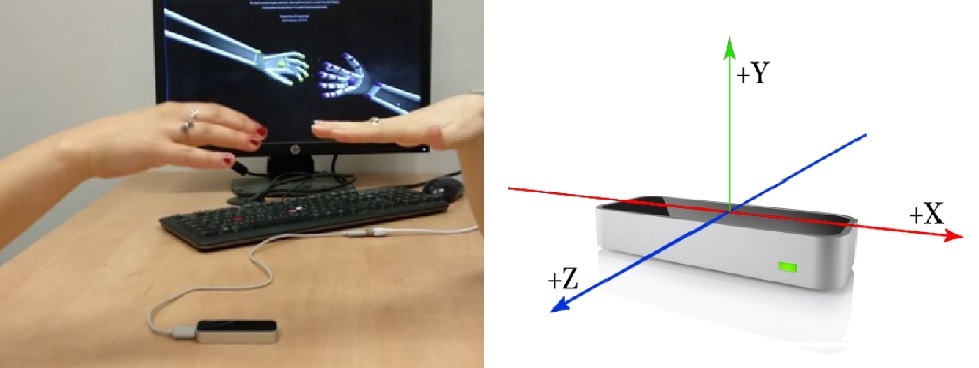

In [9]:
from IPython import display
display.Image("extraFiles/leap.jpg")

Clearly just by looking at a few files the data needs to be cleaned.

* Alone has instances with 2 hands and right hand in hand type that need to be removed. Likewise, spontaneous
and sync have instances with 1 hand and a mismatch between right and left hands.

In [10]:
def remove_first7(df):
    df.drop(df[df["Time"] < df["Time"].min() + 7].index, inplace=True)
    # drop is True to prevent from adding the old indices as a new column
    df.reset_index(drop=True, inplace=True)

In [11]:
print("Before:", handright.shape)
handright_prepared = handright.drop(handright[(handright[" Hand Type"] == "left") | (handright[" # hands"] == 2)].index)
handright_prepared.reset_index(drop=True, inplace=True)
remove_first7(handright_prepared)  # right hand file without first 7 seconds

Before: (4812, 22)


In [12]:
print("Null values:", handright_prepared.isna().sum().sum())
handright_prepared[handright_prepared.isna().any(axis=1)].head()

Null values: 2304


,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,Pitch,Roll,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
3893,201.8797,23959,right,1,-8.565041,140.3621,112.05200,32.42480,-145.06130,-160.3878,1.188079,-2.793904,-0.139680,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,0.0
3894,201.8968,23962,right,1,1.858126,112.7275,95.47443,497.33780,-642.50110,-686.8898,0.144945,0.010979,0.038722,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.418411,0.0
3895,201.9134,23963,right,1,2.825271,112.5456,91.11944,112.62890,-21.18921,-507.1606,0.143836,-0.002969,0.067269,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.379807,0.0
3896,201.9300,23965,right,1,3.694190,113.4331,82.37254,61.92186,95.66204,-499.7987,0.157899,-0.025162,0.093537,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.523864,0.0
3897,201.9464,23967,right,1,5.272612,115.7207,73.13319,107.58490,139.81950,-569.6603,0.149520,-0.008641,0.075155,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.715370,0.0


In [13]:
handright_prepared.dropna(inplace=True)
print("Null values:", handright_prepared.isna().sum().sum())
print("After:", handright_prepared.shape)
handright_prepared.head()

Null values: 0
After: (3893, 22)


,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,Pitch,Roll,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,135.3024,16287,right,1,11.93032,199.9861,4.981665,-35.512210,-165.3466,-57.68153,-0.092033,0.108262,-0.906612,75.45740,206.0521,45.38764,284.3946,140.0167,201.9318,0.0,0.561324,0.0
1,135.3194,16289,right,1,11.19190,195.3075,3.661716,-43.587440,-309.8374,-77.18515,-0.111674,0.126925,-0.904311,74.46141,202.4562,44.28679,282.6278,140.9712,203.6773,0.0,0.626321,0.0
2,135.3357,16291,right,1,10.53308,189.0297,2.829388,-30.403600,-363.0033,-43.79815,-0.140004,0.127219,-0.901862,73.60060,197.4387,43.54082,280.6384,142.5401,206.7526,0.0,0.636596,0.0
3,135.3524,16293,right,1,10.24300,181.9816,2.064330,-15.424000,-423.2120,-43.99948,-0.166623,0.122782,-0.901268,73.19537,191.7202,42.73155,279.7357,148.1382,209.9330,0.0,0.701644,0.0
4,135.3690,16295,right,1,10.02061,174.8592,1.228467,-8.733602,-413.4513,-53.88054,-0.197763,0.127587,-0.897777,72.68671,186.1613,41.98006,278.6890,152.5215,212.1112,0.0,0.786548,0.0


In [14]:
# split right hand file for training and testing
# train_size = round(len(handright_prepared) * 0.8)
# print(train_size)

# handright_prepared_train = handright_prepared.loc[:train_size].copy()
# handright_prepared_test = handright_prepared.loc[train_size:].copy()

# print("Right Hand Train\nShape:", handright_prepared_train.shape,
#      "\nNull Values:", handright_prepared_train.isna().sum().sum())
# print()
# print("Right Hand Test\nShape:", handright_prepared_test.shape,
#      "\nNull Values:", handright_prepared_test.isna().sum().sum())

> The following functions load the data into a DataFrame:

In [15]:
# function combines alone csv file with the right hand file

def combine_right(df_alone):
    # remove instances with right hand or 2 hands
    df_alone.drop(df_alone[(df_alone[" Hand Type"] == "right") | (df_alone[" # hands"] == 2)].index, inplace=True)
    df_alone.reset_index(drop=True, inplace=True)

    # copy of right hand prevents harming the DataFrame since it is used multiple times
    right = handright_prepared.copy()

    # calculate number of copies needed to match length of left hand
    n_copies = round(len(df_alone) / len(right)) + 1
    copies = []  # list for appending copies
    for i in range(n_copies):
        copies.append(right)
    right = pd.concat(copies, axis=0, ignore_index=True)  # concat DataFrame copies
    right = right.loc[:len(df_alone) - 1]  # -1 since loc includes the end index and dataframe indices start from 0

    # align column values with alone
    right.Time = df_alone.Time
    right[" Frame ID"] = df_alone[" Frame ID"]

    # merge DataFrames, sort by Time column and reset index
    merged = right.merge(df_alone, how="outer").sort_values("Time").reset_index(drop=True)
    merged[" # hands"] = 2  # change number of hands to 2 (2 hand rows were dropped per dataframe before merge)
    return merged

In [16]:
df_alone = pd.read_csv(r"extraFiles/Training/Evyatar Cohen/Evyatar636771054555711409Alone.csv")
df_alone.drop(df_alone[(df_alone[" Hand Type"] == "right") | (df_alone[" # hands"] == 2)].index, inplace=True)
df_alone.reset_index(drop=True, inplace=True)
df_alone

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,Pitch,Roll,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,518.8087,149620,left,1,-97.60160,164.1213,42.812550,104.2589,-491.6730,-55.42755,2.939312,0.045867,1.661706,-166.7207,164.8320,27.585470,-378.1662,65.89330,-69.90282,0.0,0.741855,0.0
1,518.8252,149622,left,1,-95.78062,157.6353,42.180840,148.9683,-351.7386,-36.32422,2.294397,0.074132,1.623222,-165.4907,155.6419,29.710370,-380.3233,52.92441,-55.71872,0.0,0.827916,0.0
2,518.8418,149623,left,1,-94.39360,154.6338,41.931710,161.6958,-349.9117,-29.04277,1.962658,0.086932,1.602898,-164.3658,151.5701,31.050590,-381.7444,48.55032,-47.27909,0.0,0.920401,0.0
3,518.8587,149625,left,1,-92.02553,150.6723,42.101190,117.3475,-187.1781,24.42598,1.545560,0.124819,1.567605,-162.2663,144.6214,33.945770,-383.4688,40.27151,-30.72728,0.0,1.034603,0.0
4,518.8749,149627,left,1,-89.31953,148.1826,42.670650,155.3344,-135.6337,35.87055,1.377898,0.167855,1.535920,-159.4586,138.6087,36.681950,-381.0906,29.07133,-17.01065,0.0,1.166705,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4521,593.7177,158254,left,1,-44.79453,123.7657,-6.241947,274.4463,106.7892,125.05260,1.234747,0.282478,1.476095,-114.5244,107.5486,-6.354107,-354.6525,41.16571,45.73993,0.0,0.401728,0.0
4522,593.7343,158256,left,1,-40.77390,126.7342,-3.452266,223.5294,209.7239,160.24900,1.265178,0.283400,1.484591,-110.5008,110.7256,-3.791958,-351.3217,53.68426,55.64309,0.0,0.190267,0.0
4523,593.7509,158257,left,1,-38.56184,127.6858,-2.086977,254.9331,109.6613,157.34590,1.279585,0.280169,1.489703,-108.3443,111.9989,-2.676469,-349.8930,59.75835,58.19042,0.0,0.042665,0.0
4524,593.7681,158259,left,1,-35.88303,132.9386,0.526575,185.8687,204.9822,154.04880,1.299061,0.298048,1.489702,-105.4344,116.3043,0.041351,-346.9033,66.47016,63.19174,0.0,0.000000,0.0


In [17]:
 # copy of right hand prevents harming the DataFrame since it is used multiple times
right = handright_prepared.copy()

    # calculate number of copies needed to match length of left hand
n_copies = round(len(df_alone) / len(right)) + 1
copies = []  # list for appending copies
for i in range(n_copies):
    copies.append(right)
right = pd.concat(copies, axis=0, ignore_index=True)  # concat DataFrame copies
right = right.loc[:len(df_alone) - 1]

In [18]:
pd.concat([df_alone, right], axis=0).isna().sum()

Time               0
 Frame ID          0
 Hand Type         0
 # hands           0
 Position X        0
 Position Y        0
 Position Z        0
 Velocity X        0
 Velocity Y        0
 Velocity Z        0
 Pitch             0
 Roll              0
 Yaw               0
 Wrist Pos X       0
 Wrist Pos Y       0
 Wrist Pos Z       0
 Elbow pos X       0
 Elbow Pos Y       0
 Elbow Pos Z       0
 Grab Strenth      0
 Grab Angle        0
 Pinch Strength    0
dtype: int64

In [19]:
# function returns a DataFrame with right and left hands merged into one row
# column names format is changed

def transform_columns(df):
    # strip removes white spaces in the beginning and end
    # lower changes uppercase letters to lowercase
    df.columns = df.columns.str.strip().str.lower()
    # rename columns without spaces
    df.columns = df.columns.str.replace(" ", "_")
    # change number of hands column name
    df.columns = df.columns.str.replace("#_hands", "n_hands")
    df.columns = df.columns.str.replace("grab_strenth", "grab_strength")

    # remove instances with 1 hand detected
    df.drop(df[df["n_hands"] == 1].index, inplace=True)

    # merge right and left hands into one row
    left = df.groupby("hand_type").get_group("left").drop(["hand_type", "n_hands", "frame_id"], axis=1)
    right = df.groupby("hand_type").get_group("right").drop(["hand_type", "n_hands", "frame_id"], axis=1)
    keep_same = {"state", "time"}  # shared columns
    left.columns = left.columns.map(lambda x: x if x in keep_same else x + "_left")
    right.columns = right.columns.map(lambda x: x if x in keep_same else x + "_right")
    merged = left.merge(right, how="outer", on=["state", "time"])
    # adds a column with the second
    merged.insert(1, "round_time", merged.time.astype(int) - merged.time.min().astype(int))
    # return first 4 frames per second
    return merged.groupby("round_time").nth([0, 1, 2, 3]).reset_index(drop=True) # round time is the index after groupby

> Rescaling the times in round time to start from zero rather than rounding the time values can create more diverse
> samples for each second. This is especially important for the 'alone' state, where the right hand is concatenated from
> the same file.

In [20]:
train_path = "extraFiles/Training/**/*.csv"
test_path = "extraFiles/Validation/**/*.csv"


def load_data(path, as_pandas):
    data = []
    # glob searches all directories and files
    for filename in glob.iglob(path, recursive=True):
        df = pd.read_csv(filename, index_col=None, header=0)
        remove_first7(df)  # removes first 7 seconds from file
        if "Alone" in filename:
            df = combine_right(df)
            df.insert(0, "state", 0)
        elif "Spontan" in filename:
            df.insert(0, "state", 1)
        elif "Sync" in filename:
            df.insert(0, "state", 2)
        df = transform_columns(df)
        df.set_index("time", inplace=True)
        data.append(df)
    if as_pandas:
        return pd.concat(data, axis=0, ignore_index=False)
    return data

In [21]:
# load the data
train_set = load_data(train_path, as_pandas=True)
test_set = load_data(test_path, as_pandas=True)

In [22]:
# display loaded data
train_set.head()

,state,position_x_left,position_y_left,position_z_left,velocity_x_left,velocity_y_left,velocity_z_left,pitch_left,roll_left,yaw_left,wrist_pos_x_left,wrist_pos_y_left,wrist_pos_z_left,elbow_pos_x_left,elbow_pos_y_left,elbow_pos_z_left,grab_strength_left,grab_angle_left,pinch_strength_left,position_x_right,position_y_right,position_z_right,velocity_x_right,velocity_y_right,velocity_z_right,pitch_right,roll_right,yaw_right,wrist_pos_x_right,wrist_pos_y_right,wrist_pos_z_right,elbow_pos_x_right,elbow_pos_y_right,elbow_pos_z_right,grab_strength_right,grab_angle_right,pinch_strength_right
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
343.0061,1,-102.2870,198.3166,-2.122641,-174.57210,379.14680,28.479910,1.423625,0.510471,1.481006,-164.0542,164.5314,-1.686393,-322.2086,-30.71549,11.754400,0.0,1.870325,0.0,152.3135,204.6813,-39.25671,-28.56766,23.00662,8.315823,0.654996,-0.130873,-0.563396,191.4088,170.3479,8.976357,323.5327,21.270530,162.7099,1.000000,2.793122,0.329752
343.0227,1,-103.8721,201.4944,-2.063620,-178.50250,357.85480,6.646493,1.429039,0.500107,1.486744,-165.7898,168.1620,-2.054844,-318.4708,-31.61653,7.529989,0.0,1.851572,0.0,151.8334,204.4899,-39.08438,-54.05849,-21.54555,19.405560,0.652891,-0.134715,-0.560823,190.8670,170.1528,9.191355,323.1941,20.162830,161.8589,1.000000,2.704073,0.293775
343.0392,1,-106.3691,207.4667,-2.337110,-126.78780,318.52840,-12.872290,1.441357,0.489946,1.496526,-168.4939,174.6985,-3.134404,-316.4541,-28.81729,-1.155143,0.0,1.865896,0.0,151.4056,203.4883,-38.14280,-14.11075,-56.44812,68.092860,0.637780,-0.134837,-0.554623,190.4547,169.7302,10.512530,324.1130,19.095240,161.3746,1.000000,2.422549,0.175940
343.0558,1,-107.9509,212.1324,-2.788956,-74.28078,244.48230,-30.771300,1.444497,0.483316,1.499930,-170.1878,179.6781,-4.185746,-315.3597,-25.78214,-9.287997,0.0,1.899355,0.0,151.6132,202.9217,-37.08601,21.48209,-21.23486,51.146260,0.608950,-0.142477,-0.548808,190.8024,170.2935,12.170700,323.0928,17.146000,161.7030,1.000000,2.101400,0.052777
344.0001,1,-100.1537,191.5963,-17.218380,-109.58960,-46.76116,163.174500,-0.421825,-0.401741,1.231500,-165.2294,200.7576,2.488167,-342.5831,31.40931,59.281030,0.0,0.773420,0.0,144.1773,228.7819,-40.49426,-114.62390,-84.87737,-64.320840,0.800464,-0.534337,-0.942962,196.3692,192.2109,-10.429530,308.5264,1.983945,110.3723,0.133909,1.151927,0.000000


# 2. Understanding and Visualizing the Data
> ##### *The motivation for this section is to gain more insights.*

In [23]:
hands = train_set.copy()

In [24]:
hands.head(2)

,state,position_x_left,position_y_left,position_z_left,velocity_x_left,velocity_y_left,velocity_z_left,pitch_left,roll_left,yaw_left,wrist_pos_x_left,wrist_pos_y_left,wrist_pos_z_left,elbow_pos_x_left,elbow_pos_y_left,elbow_pos_z_left,grab_strength_left,grab_angle_left,pinch_strength_left,position_x_right,position_y_right,position_z_right,velocity_x_right,velocity_y_right,velocity_z_right,pitch_right,roll_right,yaw_right,wrist_pos_x_right,wrist_pos_y_right,wrist_pos_z_right,elbow_pos_x_right,elbow_pos_y_right,elbow_pos_z_right,grab_strength_right,grab_angle_right,pinch_strength_right
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
343.0061,1,-102.2870,198.3166,-2.122641,-174.5721,379.1468,28.479910,1.423625,0.510471,1.481006,-164.0542,164.5314,-1.686393,-322.2086,-30.71549,11.754400,0.0,1.870325,0.0,152.3135,204.6813,-39.25671,-28.56766,23.00662,8.315823,0.654996,-0.130873,-0.563396,191.4088,170.3479,8.976357,323.5327,21.27053,162.7099,1.0,2.793122,0.329752
343.0227,1,-103.8721,201.4944,-2.063620,-178.5025,357.8548,6.646493,1.429039,0.500107,1.486744,-165.7898,168.1620,-2.054844,-318.4708,-31.61653,7.529989,0.0,1.851572,0.0,151.8334,204.4899,-39.08438,-54.05849,-21.54555,19.405560,0.652891,-0.134715,-0.560823,190.8670,170.1528,9.191355,323.1941,20.16283,161.8589,1.0,2.704073,0.293775


In [25]:
hands.shape

(7344, 37)

In [26]:
# check if time and state are related
hands.sort_index(inplace=False)[400:450]["state"]

time
400.0036    1
400.0120    1
400.0120    0
400.0124    1
400.0135    1
           ..
449.0501    2
449.0508    1
449.0524    0
449.0573    1
449.0660    2
Name: state, Length: 908, dtype: int64

In [27]:
hands.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 7344 entries, 343.0061 to 856.1296
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   state                 7344 non-null   int64  
 1   position_x_left       7344 non-null   float64
 2   position_y_left       7344 non-null   float64
 3   position_z_left       7344 non-null   float64
 4   velocity_x_left       7344 non-null   float64
 5   velocity_y_left       7344 non-null   float64
 6   velocity_z_left       7344 non-null   float64
 7   pitch_left            7344 non-null   float64
 8   roll_left             7344 non-null   float64
 9   yaw_left              7344 non-null   float64
 10  wrist_pos_x_left      7344 non-null   float64
 11  wrist_pos_y_left      7344 non-null   float64
 12  wrist_pos_z_left      7344 non-null   float64
 13  elbow_pos_x_left      7344 non-null   float64
 14  elbow_pos_y_left      7344 non-null   float64
 15  elbow_po

In [28]:
# check for null values
hands.isna().sum().sum()

0

In [29]:
hands.describe()

,state,position_x_left,position_y_left,position_z_left,velocity_x_left,velocity_y_left,velocity_z_left,pitch_left,roll_left,yaw_left,wrist_pos_x_left,wrist_pos_y_left,wrist_pos_z_left,elbow_pos_x_left,elbow_pos_y_left,elbow_pos_z_left,grab_strength_left,grab_angle_left,pinch_strength_left,position_x_right,position_y_right,position_z_right,velocity_x_right,velocity_y_right,velocity_z_right,pitch_right,roll_right,yaw_right,wrist_pos_x_right,wrist_pos_y_right,wrist_pos_z_right,elbow_pos_x_right,elbow_pos_y_right,elbow_pos_z_right,grab_strength_right,grab_angle_right,pinch_strength_right
count,7344.000000,7344.000000,7344.000000,7344.000000,7344.000000,7344.000000,7344.000000,7344.000000,7344.000000,7344.000000,7344.000000,7344.000000,7344.000000,7344.000000,7344.000000,7344.000000,7344.000000,7344.000000,7344.000000,7344.000000,7344.000000,7344.000000,7344.000000,7344.000000,7344.000000,7344.000000,7344.000000,7344.000000,7344.000000,7344.000000,7344.000000,7344.000000,7344.000000,7344.000000,7344.000000,7344.000000,7344.000000
mean,1.000272,-108.253822,204.945526,32.189545,-3.174176,-0.734303,-0.251167,0.995764,0.754079,1.082870,-149.808619,165.968676,40.932722,-313.863798,5.784434,75.915848,0.123910,0.834607,0.191151,92.736845,214.969103,39.521762,-3.593091,-4.319559,0.297652,0.806113,-0.622105,-0.688585,124.867907,176.559448,73.906838,267.551675,26.274057,186.987665,0.061983,0.499712,0.054327
std,0.815885,52.204000,53.748836,55.018209,146.376261,216.945899,132.101682,0.934348,1.120649,0.880024,48.361111,49.353511,47.605113,61.142588,69.507542,64.562447,0.289356,0.923492,0.332520,65.765594,55.192187,54.946067,160.040044,263.302745,187.105186,0.605776,0.674371,0.627491,73.577675,50.890072,54.961530,97.821992,62.697439,102.111303,0.209539,0.663046,0.194235
min,0.000000,-298.737100,70.183790,-156.811200,-1313.637000,-2354.559000,-1097.682000,-3.133710,-3.140818,-3.140881,-335.610400,5.609408,-115.866500,-512.740700,-188.209000,-102.684900,0.000000,0.000000,0.000000,-180.878400,59.404940,-150.438000,-1634.390000,-3180.031000,-2419.239000,-3.082958,-3.126932,-3.086131,-142.189800,23.062180,-131.666900,-28.691550,-178.969800,-57.144970,0.000000,0.000000,0.000000
25%,0.000000,-135.862800,167.844025,1.002713,-69.408880,-98.631203,-56.217703,0.654901,0.253756,0.733485,-176.270600,133.351975,13.668543,-354.544400,-41.531005,27.326663,0.000000,0.000000,0.000000,32.190038,179.707275,0.403607,-58.386583,-117.101500,-74.633340,0.407413,-1.100234,-1.130275,52.594690,146.367175,33.288220,174.469125,-14.269795,104.352475,0.000000,0.035593,0.000000
50%,1.000000,-103.085750,202.090100,31.192355,-4.174404,4.972939,2.259637,1.234546,0.911743,1.242812,-145.518850,161.014950,39.323650,-312.967400,-2.127298,75.780895,0.000000,0.531002,0.000000,112.305400,211.536800,37.309030,-0.937478,-3.671693,-4.083226,0.769098,-0.612260,-0.589396,151.675900,170.679400,74.694340,296.613200,19.358965,165.622550,0.000000,0.261249,0.000000
75%,2.000000,-76.728143,235.330175,64.328847,60.284527,108.469750,58.633913,1.582710,1.376682,1.584631,-116.096175,189.856625,65.786403,-276.459050,39.850102,124.904275,0.000000,1.306441,0.276724,143.812525,246.983375,73.601647,57.622210,111.573300,67.487358,1.269857,-0.046565,-0.163034,184.096275,200.734400,114.369650,346.559300,62.890450,276.605075,0.000000,0.657339,0.000000
max,2.000000,72.977780,478.120900,261.578300,1814.025000,1142.433000,1660.932000,3.138985,3.138921,3.139075,18.630570,437.679800,248.084500,-23.668370,377.966400,343.462200,1.000000,3.141593,1.000000,269.368900,434.498400,251.101300,1114.730000,1182.997000,1279.244000,3.136197,2.998879,0.931050,286.526900,419.043400,270.775600,503.926100,277.719100,518.593100,1.000000,3.141593,1.000000


In [30]:
hands.state.value_counts().sort_index()

0    2443
1    2456
2    2445
Name: state, dtype: int64

> Observations:
* The state and time are not related. The time relationship is per file, since the order of events is
crucial in time series data. In other words, the motion at time x is related to the motion at time x+1.
* The features have very different scales.
* There are no missing values.
* The number of rows per state is imbalanced.

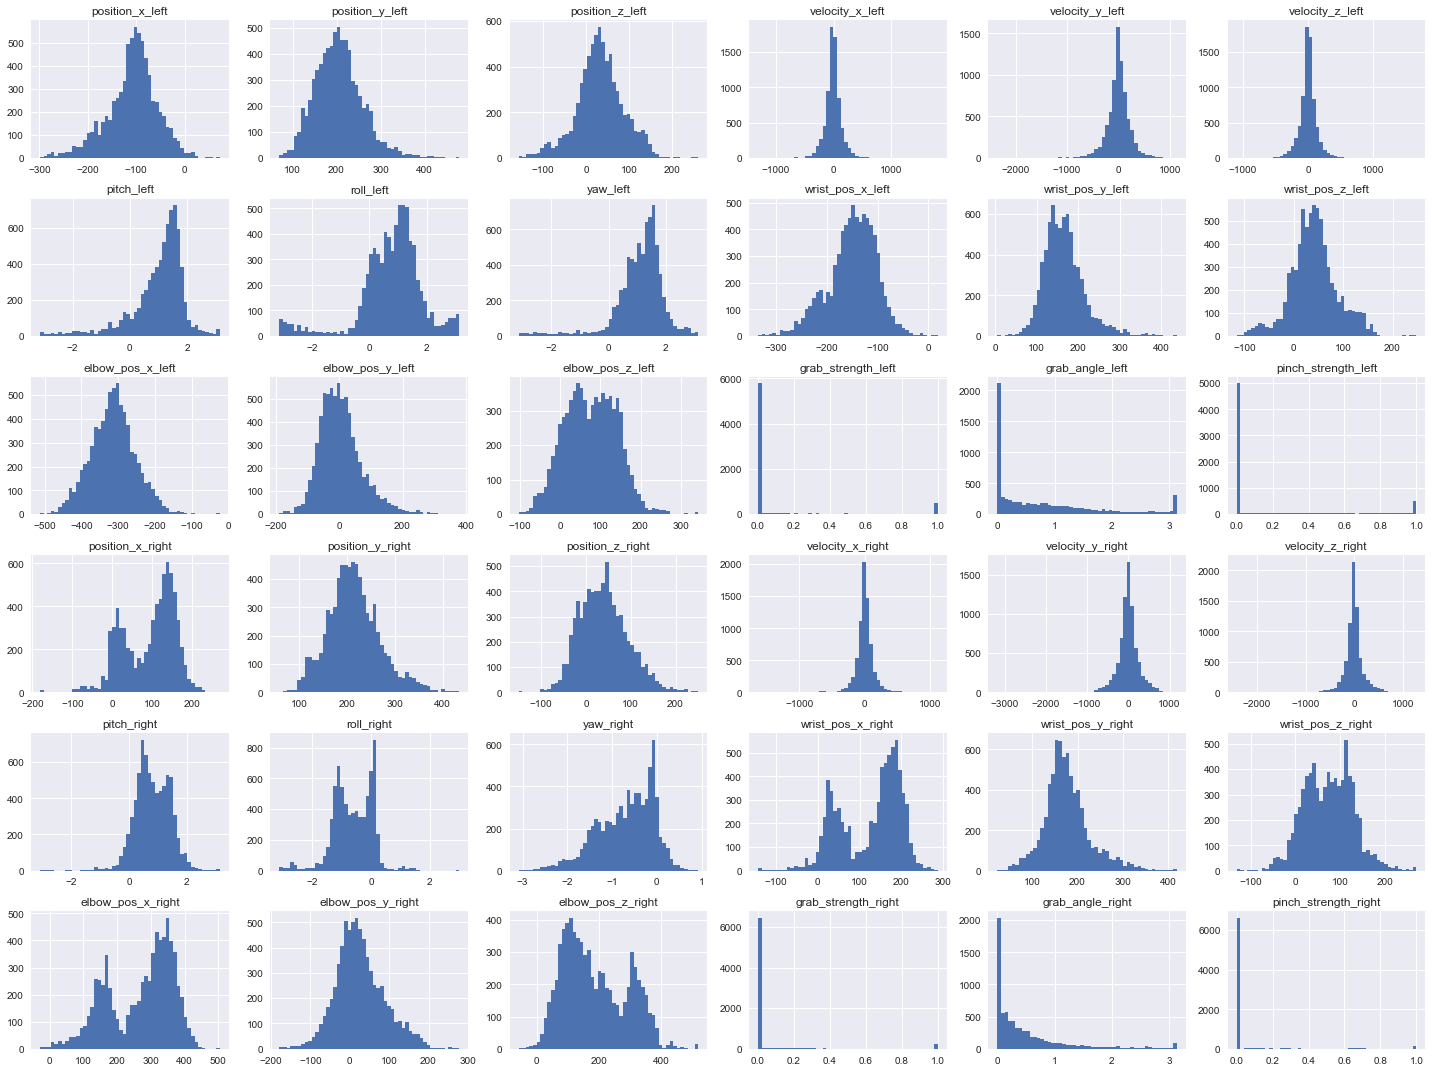

In [31]:
# histogram plot
hands.drop("state", axis=1, inplace=False).hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()

state_groups = hands.drop("time", axis=1, inplace=False).groupby("state")

state_groups.get_group(0).drop("state", axis=1, inplace=False).hist(bins=50, figsize=(20,15), color="red")
plt.suptitle("Alone", size=25)
plt.tight_layout()
plt.show()

state_groups.get_group(1).drop("state", axis=1, inplace=False).hist(bins=50, figsize=(20,15), color='orange')
plt.suptitle("Spontaneous", size=25)
plt.tight_layout()
plt.show()

state_groups.get_group(2).drop("state", axis=1, inplace=False).hist(bins=50, figsize=(20,15), color="green")
plt.suptitle("Sync", size=25)
plt.tight_layout()
plt.show()

> Initial observations from the histograms:
1. The attributes have different scales. Some values are between 0-1, while others are in the range of hundreds or
even thousands and contain negative values.
2. Most of the attributes have a relatively normal distribution. Some are a bit tail-heavy (extend farther to the
left or right).

> ### Looking for Correlations:
> Correlations measure the linear relationships between the features.
> A strong positive correlation is close to 1 and a strong negative correlation is close to -1.
> Looking for correlations with the 'state' column can emphasize which features are most significant.

In [32]:
corr_matrix = hands.corr()

In [33]:
corr_matrix["state"].sort_values(ascending=False)

state                   1.000000
elbow_pos_x_right       0.698088
wrist_pos_x_right       0.638589
position_x_right        0.596214
pitch_right             0.444962
roll_left               0.219125
pitch_left              0.160653
position_z_left         0.134694
position_y_right        0.133619
wrist_pos_z_left        0.120489
position_y_left         0.051017
grab_strength_right     0.021979
velocity_y_right        0.020658
velocity_z_left         0.008457
velocity_x_right        0.005668
velocity_y_left         0.000909
velocity_x_left        -0.003542
velocity_z_right       -0.013757
wrist_pos_y_right      -0.017460
position_z_right       -0.031239
elbow_pos_z_left       -0.035373
yaw_left               -0.037403
pinch_strength_right   -0.065048
elbow_pos_x_left       -0.083382
wrist_pos_y_left       -0.100465
grab_strength_left     -0.111268
pinch_strength_left    -0.132627
grab_angle_right       -0.154065
wrist_pos_x_left       -0.210683
grab_angle_left        -0.219886
elbow_pos_

> Observations:
* From looking at the values, clearly the right hand has a greater influence than the left.
An assumption can be made that using the same right-hand data for all the 'alone' state files had an influence
on the right-hand correlations.
* Velocity has a low correlation for both hands and all three planes.
* Pinch and grab strength

> ### Evaluating Feature Combinations

> #### Combining position and wrist pos columns (by plane and hand type):

In [34]:
pos_cols = hands.filter(regex="wrist_pos|position").columns.tolist()
pos_cols

['position_x_left',
 'position_y_left',
 'position_z_left',
 'wrist_pos_x_left',
 'wrist_pos_y_left',
 'wrist_pos_z_left',
 'position_x_right',
 'position_y_right',
 'position_z_right',
 'wrist_pos_x_right',
 'wrist_pos_y_right',
 'wrist_pos_z_right']

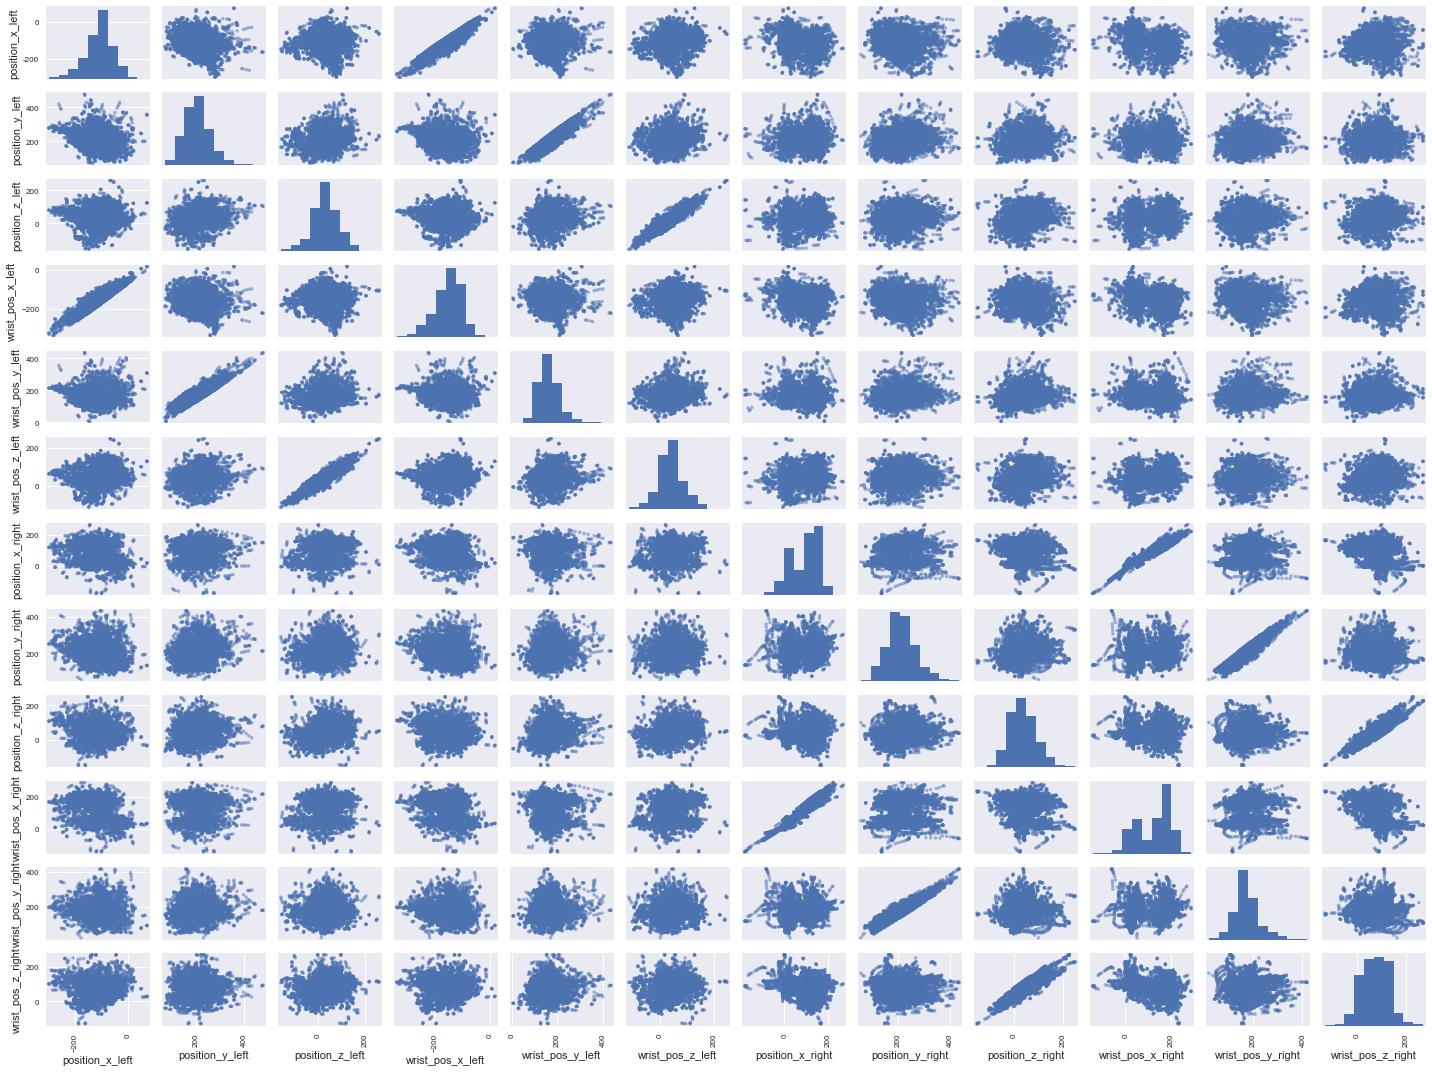

In [35]:
scatter_matrix(hands[pos_cols], figsize=(20, 15))
plt.tight_layout()
plt.show()

In [36]:
hands.groupby("state")[pos_cols].agg(["mean", "min", "max"]).T

state                            0           1           2
position_x_left   mean  -83.474228 -118.592396 -122.628058
                  min  -275.933800 -259.970900 -298.737100
                  max    72.977780  -30.605140  -14.212500
position_y_left   mean  205.323608  197.504371  212.042387
                  min    75.672810   73.511470   70.183790
                  max   417.933700  478.120900  431.102100
position_z_left   mean   19.320475   39.714382   37.489398
                  min  -156.811200  -96.954800 -116.732700
                  max   261.578300  206.326900  174.879000
wrist_pos_x_left  mean -129.744290 -164.870697 -154.726693
                  min  -265.462000 -313.916700 -335.610400
                  max    18.630570  -70.079310  -46.114980
wrist_pos_y_left  mean  173.162041  163.753164  161.006674
                  min    74.058010    5.609408   28.865990
                  max   404.798100  437.679800  368.217000
wrist_pos_z_left  mean   29.176585   50.328741   43.240950
                  min  -115.866500  -82.313100  -77.628270
                  max   248.084500  185.919400  163.745800
position_x_right  mean   19.806221  142.178175  115.944047
                  min  -180.878400   58.470720  -77.853460
                  max   241.939500  234.778600  269.368900
position_y_right  mean  204.293859  218.217046  222.373059
                  min    59.404940   77.662180  101.548100
                  max   434.498400  424.584600  408.149800
position_z_right  mean   44.107972   34.584929   39.898347
                  min   -52.827330 -150.438000 -102.657200
                  max   251.101300  214.171600  203.427300
wrist_pos_x_right mean   36.924627  185.208474  152.127213
                  min  -142.189800  115.122100  -49.984420
                  max   198.668200  276.344200  286.526900
wrist_pos_y_right mean  174.867760  182.092376  172.691932
                  min    23.062180   44.784630   57.454870
                  max   419.043400  387.753300  354.340700
wrist_pos_z_right mean  106.035619   60.167024   55.605968
                  min    -1.497380 -131.666900  -73.748400
                  max   270.775600  249.799000  252.835900

> Looking at the values that match each position according to hand type and plane, it looks like the
> values are roughly in the same range. This means that the attribute combinations can be tested
> without normalizing beforehand.
>
> I will try combining the position features by plane and hand type into one by calculating the mean, a total of
> 6 new features.

In [37]:
# compute the mean into a new column

hands["mean_pos_x_left"] = (hands["wrist_pos_x_left"] + hands["position_x_left"]) / 2
hands["mean_pos_y_left"] = (hands["wrist_pos_y_left"] + hands["position_y_left"]) / 2
hands["mean_pos_z_left"] = (hands["wrist_pos_z_left"] + hands["position_z_left"]) / 2

hands["mean_pos_x_right"] = (hands["wrist_pos_x_right"] + hands["position_x_right"]) / 2
hands["mean_pos_y_right"] = (hands["wrist_pos_y_right"] + hands["position_y_right"]) / 2
hands["mean_pos_z_right"] = (hands["wrist_pos_z_right"] + hands["position_z_right"]) / 2

In [38]:
pos_cols = hands.filter(regex="wrist_pos|position|mean_pos").columns.tolist()
pos_cols

['position_x_left',
 'position_y_left',
 'position_z_left',
 'wrist_pos_x_left',
 'wrist_pos_y_left',
 'wrist_pos_z_left',
 'position_x_right',
 'position_y_right',
 'position_z_right',
 'wrist_pos_x_right',
 'wrist_pos_y_right',
 'wrist_pos_z_right',
 'mean_pos_x_left',
 'mean_pos_y_left',
 'mean_pos_z_left',
 'mean_pos_x_right',
 'mean_pos_y_right',
 'mean_pos_z_right']

In [39]:
corr_matrix = hands.corr()
corr_matrix["state"][pos_cols].sort_values(ascending=False)

wrist_pos_x_right    0.638589
mean_pos_x_right     0.622934
position_x_right     0.596214
position_z_left      0.134694
position_y_right     0.133619
mean_pos_z_left      0.131171
wrist_pos_z_left     0.120489
mean_pos_y_right     0.062403
position_y_left      0.051017
wrist_pos_y_right   -0.017460
mean_pos_y_left     -0.022154
position_z_right    -0.031239
wrist_pos_y_left    -0.100465
mean_pos_z_right    -0.209888
wrist_pos_x_left    -0.210683
mean_pos_x_left     -0.265818
position_x_left     -0.305930
wrist_pos_z_right   -0.374263
Name: state, dtype: float64

> Observations:
* Overall, it seems that the new columns represent the correlation well.
It will be useful to implement a transformer for this to easily evaluate the results during model training.
* This feature combination could possibly be used instead of the original features, which would reduce
dimensionality a bit.

> #### Combining grab strength and angle columns:

In [40]:
# get list of column names
grab_cols = hands.filter(regex="grab").columns.tolist()
grab_cols

['grab_strength_left',
 'grab_angle_left',
 'grab_strength_right',
 'grab_angle_right']

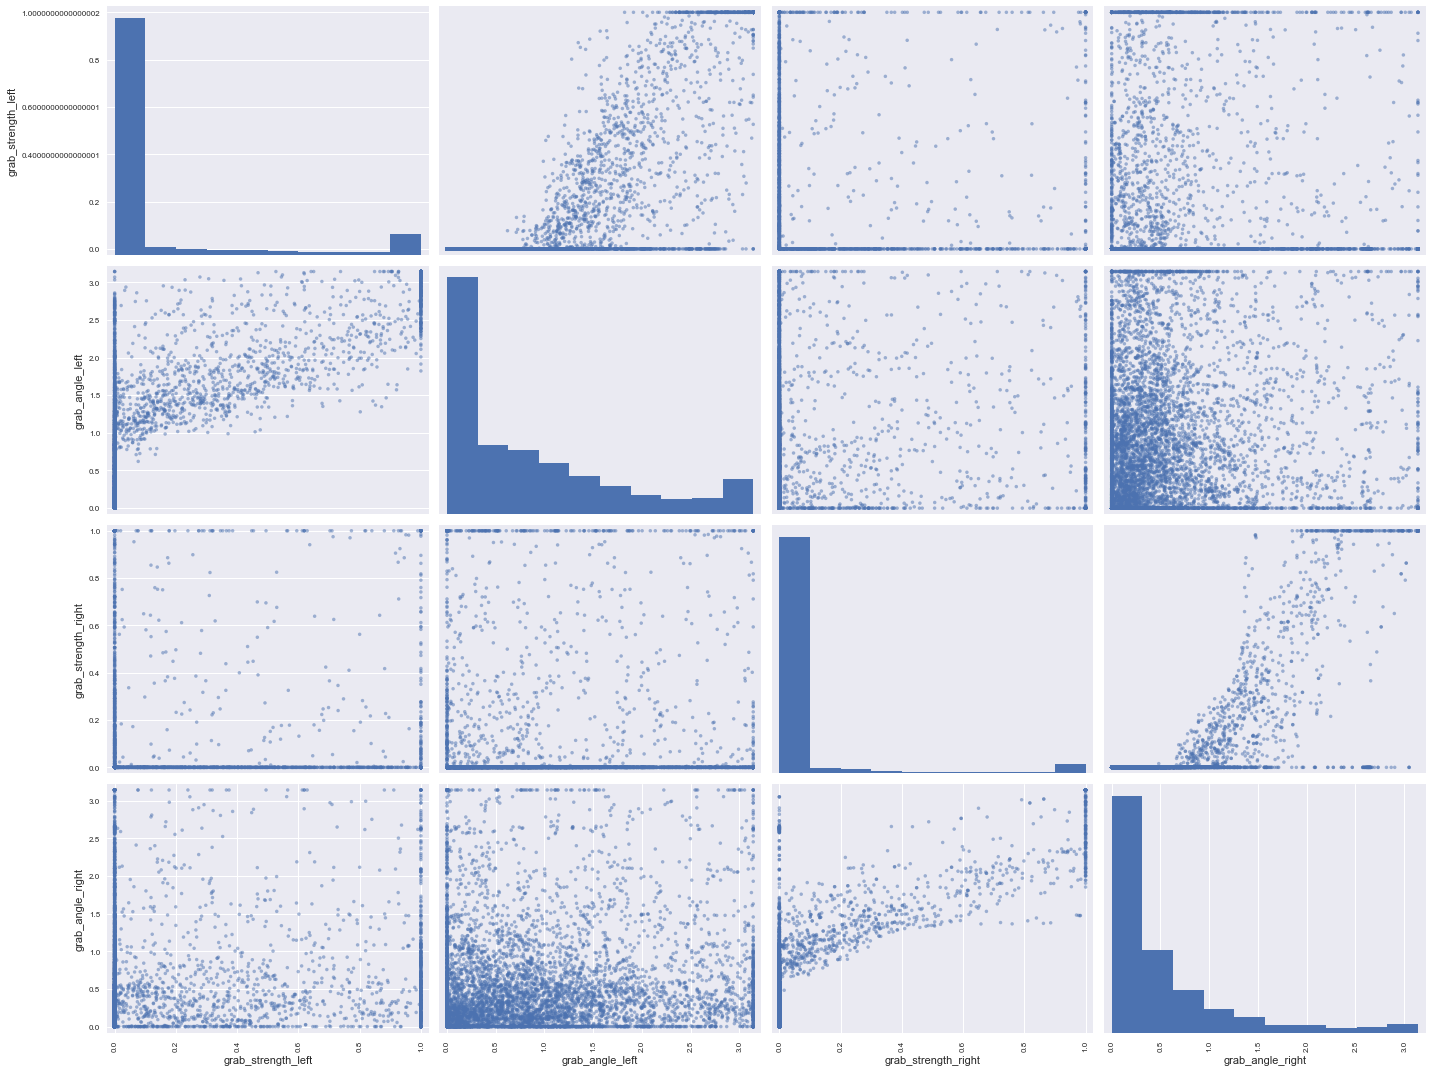

In [41]:
# plot correlation matrix
scatter_matrix(hands[grab_cols], figsize=(20, 15))
plt.tight_layout()
plt.show()

> There is a pretty strong correlation between the grab angle and strength for each hand type.

In [42]:
# aggregate columns by alignment state
hands.groupby("state")[grab_cols].agg(["mean", "min", "max"]).T

state                            0         1         2
grab_strength_left  mean  0.158658  0.133319  0.079739
                    min   0.000000  0.000000  0.000000
                    max   1.000000  1.000000  1.000000
grab_angle_left     mean  1.013777  0.973506  0.516060
                    min   0.000000  0.000000  0.000000
                    max   3.141593  3.141593  3.141593
grab_strength_right mean  0.057874  0.058921  0.069162
                    min   0.000000  0.000000  0.000000
                    max   1.000000  1.000000  1.000000
grab_angle_right    mean  0.616197  0.517158  0.365796
                    min   0.000000  0.000000  0.000000
                    max   3.141593  3.141593  3.141593

> It is clear that strength is a value between 0 and 1 and the angle is between 0 and pi.
> In order to combine these features, I will first normalize the angle range to 0 and 1,
> then compute the mean, adding 2 new columns.

In [43]:
# normalize angle values to the same scale as grab strength
# angle = [0, pi], grab strength = [0, 1]
grab_angle_left_norm = hands["grab_angle_left"] / hands["grab_angle_left"].max()
grab_angle_right_norm = hands["grab_angle_right"] / hands["grab_angle_right"].max()

# compute the mean into a new column
hands["grab_left"] = (hands["grab_strength_left"] + grab_angle_left_norm) / 2
hands["grab_right"] = (hands["grab_strength_right"] + grab_angle_right_norm) / 2

In [44]:
# get list with added columns
grab_cols = hands.filter(regex="grab").columns.tolist()
grab_cols

['grab_strength_left',
 'grab_angle_left',
 'grab_strength_right',
 'grab_angle_right',
 'grab_left',
 'grab_right']

In [45]:
# show correlation with added columns
corr_matrix = hands.corr()
corr_matrix["state"][grab_cols].sort_values(ascending=False)

grab_strength_right    0.021979
grab_right            -0.070168
grab_strength_left    -0.111268
grab_angle_right      -0.154065
grab_left             -0.175406
grab_angle_left       -0.219886
Name: state, dtype: float64

> Observations:
* While grab left seems to provide a seemingly high correlation, grab right very little correlation
compared to grab angle right, which is a lot more correlated.
* Grab strength right has a positive correlation, unlike grab angle right and the newly combined feature, grab right.
* Overall, it seems that the new features mostly cause information loss and don't provide much more information
(especially the grab right feature, which is hardly correlated).
Therefore, I will not use it for further analysis.

In [46]:
# drop the combined feature columns
hands.drop(["grab_left", "grab_right"], axis=1, inplace=True)

> Taking another look at the correlations:

In [47]:
corr_matrix = hands.corr()
corr_matrix["state"].sort_values(ascending=False)

state                   1.000000
elbow_pos_x_right       0.698088
wrist_pos_x_right       0.638589
mean_pos_x_right        0.622934
position_x_right        0.596214
pitch_right             0.444962
roll_left               0.219125
pitch_left              0.160653
position_z_left         0.134694
position_y_right        0.133619
mean_pos_z_left         0.131171
wrist_pos_z_left        0.120489
mean_pos_y_right        0.062403
position_y_left         0.051017
grab_strength_right     0.021979
velocity_y_right        0.020658
velocity_z_left         0.008457
velocity_x_right        0.005668
velocity_y_left         0.000909
velocity_x_left        -0.003542
velocity_z_right       -0.013757
wrist_pos_y_right      -0.017460
mean_pos_y_left        -0.022154
position_z_right       -0.031239
elbow_pos_z_left       -0.035373
yaw_left               -0.037403
pinch_strength_right   -0.065048
elbow_pos_x_left       -0.083382
wrist_pos_y_left       -0.100465
grab_strength_left     -0.111268
pinch_stre

# 3. Data Cleaning

In [48]:
# clean copy of the training set
df = train_set.copy()

In [49]:
# BaseEstimator for enabling hyperparameters
# TransformerMixin adds fit_transform method
class CombinedFeaturesAdder(BaseEstimator, TransformerMixin):

    def __init__(self, combine_position_wrist=False):
        self.combine_position_wrist = combine_position_wrist

    def fit(self, X, y=None):
        return self # no fitting needed

    def transform(self, X):
        mean_pos_x_left = (X["wrist_pos_x_left"] + X["position_x_left"]) / 2
        mean_pos_y_left = (X["wrist_pos_y_left"] + X["position_y_left"]) / 2
        mean_pos_z_left = (X["wrist_pos_z_left"] + X["position_z_left"]) / 2
        mean_pos_x_right = (X["wrist_pos_x_right"] + X["position_x_right"]) / 2
        mean_pos_y_right = (X["wrist_pos_y_right"] + X["position_y_right"]) / 2
        mean_pos_z_right = (X["wrist_pos_z_right"] + X["position_z_right"]) / 2
        if self.combine_position_wrist:
            # np.c_ concatenates slice objects along the second axis
            return np.c_[X, mean_pos_x_left, mean_pos_y_left, mean_pos_z_left,
                         mean_pos_x_right, mean_pos_y_right, mean_pos_z_right]
        return X.to_numpy() # return also in numpy format

hands = train_set.copy()
feat_adder = CombinedFeaturesAdder(combine_position_wrist=False)
feat_adder2 = CombinedFeaturesAdder(combine_position_wrist=True)
before = pd.DataFrame(feat_adder.transform(hands))
after = pd.DataFrame(feat_adder2.transform(hands))
after.drop([38, 39, 40, 41, 42, 43], axis=1, inplace=True)
(before != after).sum().sum()
#before

> ### Feature Scaling
>
> Chosen feature scale:
>
> Standardizing centers the data so that it has a zero mean and a standard deviation of 1, under the assumption
> that the data is normally distributed.
* The distribution is relatively normal.
* PCA assumes the data has zero mean and could be a useful dimensionality reduction technique,
since the values can be considered as continuous.
>
> Therefore, standard scaling is the ideal option.

In [50]:
full_pipeline = Pipeline([
    ("feat_adder", CombinedFeaturesAdder()),
    ("std_scl", StandardScaler())
])

sep = load_data(train_path, as_pandas=False)
sep[0].time = sep[0].time.round()
df = sep[0]
df_shift = df.shift(1)

keep_same = {"state", "time"}
df_shift.columns = df_shift.columns.map(lambda x: x if x in keep_same else x + "_shift")
df.merge(df_shift, on=["state", "time"]).dropna()

df1 = df.groupby("time").apply(lambda df: df.reset_index(drop=True)).unstack().sort_index(axis=1, level=1).reset_index()
df1


df1.columns = df1.columns.droplevel(1)

df1
#df1.elbow_pos_x_left

# 4. Training and Evaluating Models

> Since there is a slight imbalance between the classes, accuracy can be a bit deceiving.
> Evaluating by a metric that represents the data better is important.
>
> Chosen evaluation metric:
>
> The F1 Score is calculated by using precision (the accuracy of the positive predictions) and
> recall (the ratio of positive instances correctly classified) accuracy.
> This metric gives a higher value towards false positives rather than false negatives.

In [52]:
# function prints scores
def display_evaluation(actual, pred):
    print("Confusion Matrix:\n", metrics.confusion_matrix(actual, pred), "\n")
    print("Classification Report:\n", metrics.classification_report(actual, pred))

> Time series data is sensitive and shuffling the data could be problematic. For instance, if the model
> was trained on the hand motion at time x-1 and x+1, it should easily be able to predict the state of the motion
> at time x. Therefore, regular model evaluations can not be used here.
>
> In this case, there are two main approaches that can be used to evaluate the models during training:
1. Take the last 5 seconds from each file for the validation set and remove an additional 2 seconds to
create a time gap (otherwise, the models should easily be able to predict the state of the motion that occurred
a second later).
2. Train the model using the data of one person and evaluate with the second, then train the first two
people and evaluate with the third, and so on.

### Notes:

01:37:00

- Organize the data in a pandas dataframe
- Goal: using the hand ... , detect if is alone, sync or spontaneous.
- "spontaneous synchronizing"
- interpersonal space
- training has 9 participants
- validation has different participants
- spontan and sync: if # hands is 1, remove data!
- time series
- every 2 lines is one feature (need to be combined) = 1 frame
- choose how many frames
- position y is similar
- 2 recordings, second is usually better
- can't split train and test as usual (correlation between each following movement). can't shuffle!
for instance, can take first 40 seconds for training and last 5 for testing.
- at least 2 seconds in between train and test
- model for 1 person, try model on second person. train the second person and test the third etc.
- 4 frames per second
-

> #### Resources:
1. Leap Motion Attributes <a href="https://developer-archive.leapmotion.com/documentation/python/api/Leap.Hand.html"
> title="leapmotion">link</a>

training_data = []

# glob searches all directories and files
for filename in glob.iglob("extraFiles/Training/**/*.csv", recursive=True):
    df = pd.read_csv(filename, index_col=None, header=0)
    remove_first7(df) # removes first 7 seconds from file
    if "Alone" in filename:
        df = combine_right(df, False)
        df.insert(0, "state", 0)
    elif "Sync" in filename:
        df.insert(0, "state", 1)
    elif "Spontan" in filename:
        df.insert(0, "state", 2)
    df = transform_columns(df)
    training_data.append(df)

# function returns a DataFrame with right and left hands merged into one row
# column names format is changed

def transform_columns2(df):
    # strip removes white spaces in the beginning and end
    # lower changes uppercase letters to lowercase
    df.columns = df.columns.str.strip().str.lower()
    # rename columns without spaces
    df.columns = df.columns.str.replace(" ", "_")
    # change number of hands column name
    df.columns = df.columns.str.replace("#_hands", "n_hands")
    df.columns = df.columns.str.replace("grab_strenth", "grab_strength")

    # remove instances with 1 hand detected
    df.drop(df[df["n_hands"] == 1].index, inplace=True)

    # merge right and left hands into one row
    left = df.groupby("hand_type").get_group("left").drop(["hand_type", "n_hands", "frame_id"], axis=1)
    right = df.groupby("hand_type").get_group("right").drop(["hand_type", "n_hands", "frame_id"], axis=1)
    keep_same = {"state", "time"}  # shared columns
    left.columns = left.columns.map(lambda x: x if x in keep_same else x + "_left")
    right.columns = right.columns.map(lambda x: x if x in keep_same else x + "_right")
    return left.merge(right, how="outer", on=["state", "time"])

# function combines alone csv file with the right hand file

def combine_right2(df_alone, is_test):
    # remove instances with right hand or 2 hands
    df_alone.drop(df_alone[(df_alone[" Hand Type"] == "right") | (df_alone[" # hands"] == 2)].index, inplace=True)
    df_alone.reset_index(drop=True, inplace=True)

    # copy of right hand according to train / test
    # prevents harming the DataFrame since it is used multiple times
    if is_test:
        right = handright_prepared_test.copy()
    else:
        right = handright_prepared_train.copy()

    # calculate number of copies needed to match length of left hand
    if len(right) > len(df_alone):
        right = right.loc[:len(df_alone) - 1]  # -1 since loc includes the end index and dataframe indices start from 0
    else:
        df_alone = df_alone.loc[:len(right)-1]
    # align column values with alone
    right.Time = df_alone.Time
    right[" Frame ID"] = df_alone[" Frame ID"]

    # merge DataFrames, sort by Time column and reset index
    merged = right.merge(df_alone, how="outer").sort_values("Time").reset_index(drop=True)
    merged[" # hands"] = 2  # change number of hands to 2 (2 hand rows were dropped per dataframe before merge)
    return merged

# function combines alone csv file with the right hand file

def combine_right(df_alone, is_test):
    # remove instances with right hand or 2 hands
    df_alone.drop(df_alone[(df_alone[" Hand Type"] == "right") | (df_alone[" # hands"] == 2)].index, inplace=True)
    df_alone.reset_index(drop=True, inplace=True)

    # copy of right hand according to train / test
    # prevents harming the DataFrame since it is used multiple times
    if is_test:
        right = handright_prepared_test.copy()
    else:
        right = handright_prepared_train.copy()

    # calculate number of copies needed to match length of left hand
    n_copies = round(len(df_alone) / len(right)) + 1
    copies = []  # list for appending copies
    for i in range(n_copies):
        copies.append(right)
    right = pd.concat(copies, axis=0, ignore_index=True)  # concat DataFrame copies
    right = right.loc[:len(df_alone) - 1]  # -1 since loc includes the end index and dataframe indices start from 0

    # align column values with alone
    right.Time = df_alone.Time
    right[" Frame ID"] = df_alone[" Frame ID"]

    # merge DataFrames, sort by Time column and reset index
    merged = right.merge(df_alone, how="outer").sort_values("Time").reset_index(drop=True)
    merged[" # hands"] = 2  # change number of hands to 2 (2 hand rows were dropped per dataframe before merge)
    return merged

alone["Time"] = alone["Time"] - alone["Time"].min()

    # reset index (drop = False) adds round time as the left column in the DataFrame
    df = df.groupby("start_time").nth([0, 1, 2, 3]).reset_index() # first four instances per second

In [640]:
# adds a column with the second
new.insert(1, "round_time", new.time.astype(int) - new.time.min().astype(int))

NameError: name 'new' is not defined

In [ ]:
new

In [ ]:
# round time is the index after groupby
merged = new.groupby("round_time").nth([0, 1, 2, 3, 4]).reset_index(drop=True)

In [ ]:
merged.head(10)

In [ ]:
merged.isna().sum()

In [650]:
merged


NameError: name 'merged' is not defined

In [651]:
# function splits training data into a training set and validations set
# 2 second difference between train and validation

def split_train_val(data):
    train = []
    val = []
    for i in range(len(data)):
        df = data[i]
        train.append(df.drop(df[df["time"] > df["time"].max() - 7].index)) # drop last 7 seconds
        val.append(df.drop(df[df["time"] < df["time"].max() - 5].index)) # append last 5 seconds
    trainX = pd.concat(train, axis=0, ignore_index=True)
    valX = pd.concat(val, axis=0, ignore_index=True)
    return trainX, valX

In [652]:
trainX, valX = split_train_val(load_data(train_path, as_pandas=False))

In [655]:
trainX.set_index("time", inplace=True)
valX.set_index("time", inplace=True)

In [656]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

#trainX.drop("time", axis=1, inplace=True)
#valX.drop("time", axis=1, inplace=True)
X_train = trainX.drop("state", axis=1)
y_train = trainX.state.copy()
X_val = valX.drop("state", axis=1)
y_val = valX.state.copy()

In [658]:
X_train_prep = full_pipeline.fit_transform(X_train)

In [659]:
X_val_prep = full_pipeline.transform(X_val)

In [660]:
knn = KNeighborsClassifier()
knn.fit(X_train_prep, y_train)

KNeighborsClassifier()

In [661]:
pred = knn.predict(X_val_prep)

In [662]:
print(metrics.classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       181
           1       0.89      0.78      0.83       185
           2       0.80      0.89      0.85       185

    accuracy                           0.89       551
   macro avg       0.89      0.89      0.89       551
weighted avg       0.89      0.89      0.89       551



In [646]:
print(metrics.classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       181
           1       0.89      0.78      0.83       185
           2       0.80      0.89      0.85       185

    accuracy                           0.89       551
   macro avg       0.89      0.89      0.89       551
weighted avg       0.89      0.89      0.89       551



In [379]:
print(metrics.classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       226
           1       0.91      0.81      0.86       230
           2       0.83      0.92      0.87       230

    accuracy                           0.91       686
   macro avg       0.91      0.91      0.91       686
weighted avg       0.91      0.91      0.91       686



In [360]:
print(metrics.classification_report(y_val, pred))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       226
           1       0.90      0.81      0.85       230
           2       0.83      0.91      0.87       230

    accuracy                           0.90       686
   macro avg       0.91      0.90      0.90       686
weighted avg       0.90      0.90      0.90       686



In [356]:
print(metrics.classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       226
           1       0.89      0.82      0.85       230
           2       0.83      0.90      0.86       230

    accuracy                           0.90       686
   macro avg       0.90      0.90      0.90       686
weighted avg       0.90      0.90      0.90       686



In [647]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train_prep, y_train)

RandomForestClassifier()

In [648]:
pred = rf_clf.predict(X_val_prep)

In [649]:
print(metrics.classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       181
           1       0.88      0.92      0.90       185
           2       0.91      0.87      0.89       185

    accuracy                           0.93       551
   macro avg       0.93      0.93      0.93       551
weighted avg       0.93      0.93      0.93       551



In [382]:
print(metrics.classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       226
           1       0.98      0.87      0.92       230
           2       0.89      0.98      0.93       230

    accuracy                           0.95       686
   macro avg       0.95      0.95      0.95       686
weighted avg       0.95      0.95      0.95       686



In [363]:
print(metrics.classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       226
           1       0.97      0.84      0.90       230
           2       0.86      0.97      0.91       230

    accuracy                           0.94       686
   macro avg       0.94      0.94      0.94       686
weighted avg       0.94      0.94      0.94       686



In [251]:
print(metrics.classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       226
           1       0.97      0.86      0.91       230
           2       0.87      0.97      0.92       230

    accuracy                           0.94       686
   macro avg       0.95      0.94      0.94       686
weighted avg       0.95      0.94      0.94       686

